# ARCH Modelling

ARCH models are commonly employed in modeling financial time series that exhibit time-varying volatility clustering, i.e. periods of swings interspersed with periods of relative calm. ARCH-type models are sometimes considered to be in the family of stochastic volatility models, although this is strictly incorrect since at time t the volatility is completely pre-determined (deterministic) given previous values.

In econometrics, the autoregressive conditional heteroskedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms.

Credits: Bash Tage 

Source: https://github.com/bashtage/arch


In [52]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn
#import matplotlib.pyplot as plt
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90
import pandas as pd
from datetime import datetime

### Import Data

In [63]:
input_data = pd.read_csv('dataset/YM_170602_180123_1min.csv')
adjusted_data = input_data.drop(['Unnamed: 0'], axis = 1)
#reindexed_data = adjusted_data.set_index('date')
#close = reindexed_data['close']
close = adjusted_data['close']
returns = 100*close.pct_change().dropna()

In [64]:
adjusted_data.head()

,date,open,high,low,close,volume,barCount,average,onlyDate,time
0,2017-06-02 21:30:00,21060.0,21060.0,21060.0,21060.0,0,0,21060.0,2017-06-02,21:30:00
1,2017-06-02 21:31:00,21060.0,21060.0,21060.0,21060.0,0,0,21060.0,2017-06-02,21:31:00
2,2017-06-02 21:32:00,21060.0,21060.0,21060.0,21060.0,0,0,21060.0,2017-06-02,21:32:00
3,2017-06-02 21:33:00,21060.0,21060.0,21060.0,21060.0,0,0,21060.0,2017-06-02,21:33:00
4,2017-06-02 21:34:00,21060.0,21060.0,21060.0,21060.0,0,0,21060.0,2017-06-02,21:34:00


In [59]:
datetime_object = datetime.strptime(adjusted_data['date'][0], '%Y-%m-%d %H:%M:%S')

In [57]:
datetime_object

datetime.datetime(2017, 6, 2, 21, 30)

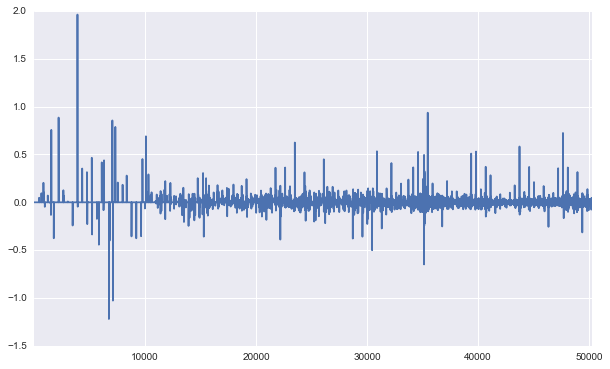

In [65]:
figure = returns.plot()

## Specifying Common Models

The simplest way to specify a model is to use the model constructor arch.arch_model which can specify most common models. The simplest invocation of arch will return a model with a constant mean, GARCH(1,1) volatility process and normally distributed errors.

$$ r_t  =  \mu + \epsilon_t$$$$\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $$$$\epsilon_t  =  \sigma_t e_t,\,\,\, e_t  \sim  N(0,1) $$
The model is estimated by calling fit. The optional inputs iter controls the frequency of output form the optimizer, and disp controls whether convergence information is returned. The results class returned offers direct access to the estimated parameters and related quantities, as well as a summary of the estimation results.

### GARCH (with a constant mean)

The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.

In [66]:
from arch import arch_model
am = arch_model(returns) 
res = am.fit(update_freq=5)
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115733.49847469313
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                115733.
Distribution:                  Normal   AIC:                          -231459.
Method:            Maximum Likelihood   BIC:                          -231424.
                                        No. Observations:                50253
Date:                Sat, Jan 27 2018   Df Residuals:                    50249
Time:                        22:08:45   Df Model:                            4
                                 Mean Model                                 
  

plot() can be used to quickly visualize the standardized residuals and conditional volatility.

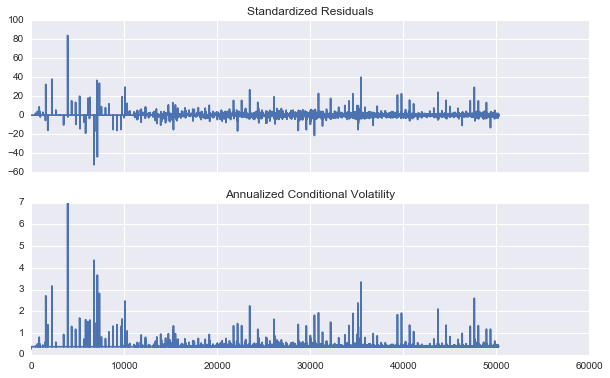

In [67]:
fig = res.plot(annualize='D')

### GJR-GARCH

Additional inputs can be used to construct other models. This example sets o to 1, which includes one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics given by

$$ sigma^2_t   =  omega + alpha epsilon_{t-1}^2 + gamma epsilon_{t-1}^2 I_{[epsilon_{t-1}<0]}+ beta sigma_{t-1}^2  $$


where $I$ is an indicator function that takes the value 1 when its argument is true.

The log likelihood improves substantially with the introduction of an asymmetric term, and the parameter estimate is highly significant.

In [68]:
am = arch_model(returns, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                115951.
Distribution:                  Normal   AIC:                          -231892.
Method:            Maximum Likelihood   BIC:                          -231848.
                                        No. Observations:                50253
Date:                Sat, Jan 27 2018   Df Residuals:                    50248
Time:                        22:18:02   Df Model:                            5
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.8041e-04  1.178e-04      4.080  4.507e-05 [2.

### TARCH/ZARCH

TARCH (also known as ZARCH) model the volatility using absolute values. This model is specified using power=1.0 since the default power, 2, corresponds to variance processes that evolve in squares.

The volatility process in a TARCH model is given by



$$ sigma_t  =  omega + alpha epsilon_{t-1} + gamma epsilon_{t-1} I_{[epsilon_{t-1}<0]}+ beta sigma_{t-1} $$

More general models with other powers ($\kappa$) have volatility dynamics given by


$$sigma_t^kappa   = omega + alpha |epsilon_{t-1}|^kappa + gamma |epsilon_{t-1}|^kappa I_{[epsilon_{t-1}<0]}+ beta sigma_{t-1}^kappa 
$$

where the conditional variance is $\left(\sigma_t^\kappa\right)^{2/\kappa}$.

The TARCH model also improves the fit, although the change in the log likelihood is less dramatic.

In [77]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     64,   Neg. LLF: -115617.67120937067
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -115617.67102683918
            Iterations: 9
            Function evaluations: 64
            Gradient evaluations: 5
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                  close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                TARCH/ZARCH   Log-Likelihood:                115618.
Distribution:                  Normal   AIC:                          -231225.
Method:            Maximum Likelihood   BIC:                          -231181.
                                        No. Observations:                50253
Date:                Sat, Jan 27 2018   Df Residuals:                    50248
Time:                        22:32:05   Df Model:                          

/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


### Student's T Errors

Financial returns are often heavy tailed, and a Student's T distribution is a simple method to capture this feature. The call to arch changes the distribution from a Normal to a Students's T.

The standardized residuals appear to be heavy tailed with an estimated degree of freedom near 10. The log-likelihood also shows a large increase.

In [78]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     62,   Neg. LLF: 240215.27496283146
Iteration:     10,   Func. Count:    119,   Neg. LLF: -22607.7787155081
Iteration:     15,   Func. Count:    199,   Neg. LLF: 3068776.8422565446
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 3068776.838845583
            Iterations: 19
            Function evaluations: 199
            Gradient evaluations: 15


/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                        close   R-squared:           -108321522268.950
Mean Model:                   Constant Mean   Adj. R-squared:      -108321522268.950
Vol Model:                      TARCH/ZARCH   Log-Likelihood:           -3.06878e+06
Distribution:      Standardized Student's t   AIC:                       6.13757e+06
Method:                  Maximum Likelihood   BIC:                       6.13762e+06
                                              No. Observations:                50253
Date:                      Sat, Jan 27 2018   Df Residuals:                    50247
Time:                              22:33:45   Df Model:                            6
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

### Fixing Parameters

In some circumstances, fixed rather than estimated parameters might be of interest. A model-result-like class can be generated using the fix() method. The class returend is identical to the usual model result class except that information about inference (standard errors, t-stats, etc) is not available.

In the example, I fix the parameters to a symmetric version of the previously estimated model.

In [79]:
fixed_res = am.fix([0.0235, 0.01, 0.06, 0.0, 0.9382, 8.0])
print(fixed_res.summary())

                      Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                         close   R-squared:                          --
Mean Model:                    Constant Mean   Adj. R-squared:                     --
Vol Model:                       TARCH/ZARCH   Log-Likelihood:                42907.4
Distribution:       Standardized Student's t   AIC:                          -85802.7
Method:            User-specified Parameters   BIC:                          -85749.8
                                               No. Observations:                50253
Date:                       Sat, Jan 27 2018                                         
Time:                               22:40:00                                         
      Mean Model     
                 coef
---------------------
mu             0.0235
   Volatility Model  
                 coef
---------------------
omega          0.0100
alpha[1]       0.0600
gamma[1]       0.0000
beta[1

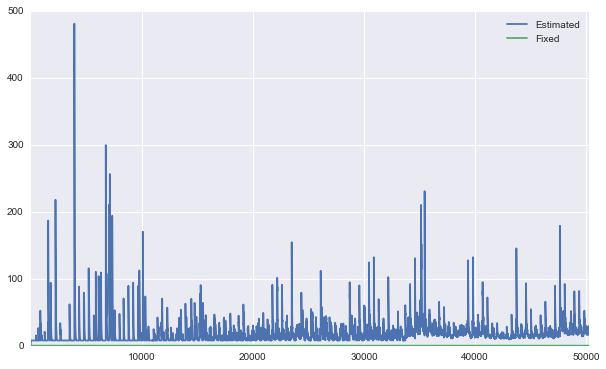

In [85]:
df = pd.concat([res.conditional_volatility,fixed_res.conditional_volatility],1)
df.columns = ['Estimated', 'Fixed']
df.plot()

## Building a Model from Components


Models can also be systematically assembled from the three model components:

- A mean model (arch.mean)
    - Zero mean (ZeroMean) - useful if using residuals from a model estimated separately
    - Constant mean (ConstantMean) - common for most liquid financial assets
    - Autoregressive (ARX) with optional exogenous regressors
    - Heterogeneous (HARX) autoregression with optional exogenous regressors
    - Exogenous regressors only (LS)
- A volatility process (arch.volatility)
    - ARCH (ARCH)
    - GARCH (GARCH)
    - GJR-GARCH (GARCH using o argument)
    - TARCH/ZARCH (GARCH using power argument set to 1)
    - Power GARCH and Asymmetric Power GARCH (GARCH using power)
    - Exponentially Weighted Moving Average Variance with estimated coefficient (EWMAVariance)
    - Heterogeneous ARCH (HARCH)
    - Parameterless Models
    - Exponentially Weighted Moving Average Variance, known as RiskMetrics (EWMAVariance)
    - Weighted averages of EWMAs, known as the RiskMetrics 2006 methodology (RiskMetrics2006)
- A distribution (arch.distribution)
    - Normal (Normal)
    - Standardized Students's T (StudentsT)

### Mean Models

The first choice is the mean model. For many liquid financial assets, a constant mean (or even zero) is adequate. For other series, such as inflation, a more complicated model may be required. 

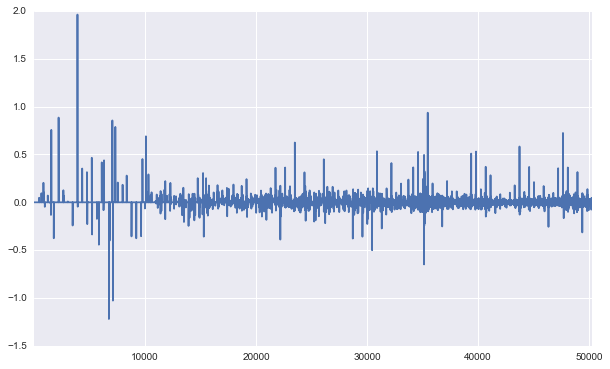

In [87]:
returns = 100*close.pct_change().dropna()
fig = returns.plot()

All mean models are initialized with constant variance and normal errors. For ARX models, the lags argument specifies the lags to include in the model.

In [88]:
from arch.univariate import ARX
ar = ARX(returns, lags = [1, 3, 12])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                  close   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:                114916.
Distribution:                  Normal   AIC:                          -229823.
Method:            Maximum Likelihood   BIC:                          -229778.
                                        No. Observations:                50241
Date:                Sat, Jan 27 2018   Df Residuals:                    50236
Time:                        22:50:35   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      4.4399e-04  1.106e-04      4.016  5.919e-05 

### Volatility Processes

Volatility processes can be added a a mean model using the volatility property. This example adds an ARCH(5) process to model volatility. The arguments iter and disp are used in fit() to suppress estimation output.

In [89]:
from arch.univariate import ARCH, GARCH
ar.volatility = ARCH(p=5)
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                           AR - ARCH Model Results                            
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                115707.
Distribution:                  Normal   AIC:                          -231394.
Method:            Maximum Likelihood   BIC:                          -231306.
                                        No. Observations:                50241
Date:                Sat, Jan 27 2018   Df Residuals:                    50231
Time:                        22:51:45   Df Model:                           10
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const       5.4211e-04  1.458e-04      3.717  2.0


Plotting the standardized residuals and the conditional volatility shows some large (in magnitude) errors, even when standardized.

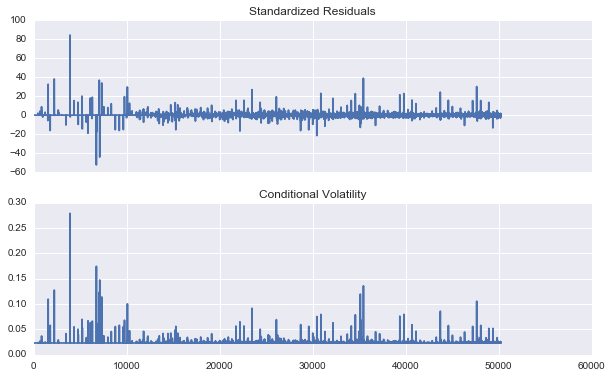

In [90]:
fig = res.plot()

### Distributions


Finally the distribution can be changed from the default normal to a standardized Student's T using the distribution property of a mean model.

The Student's t distribution improves the model, and the degree of freedom is estimated to be near 8.

In [91]:

from arch.univariate import StudentsT
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                               AR - ARCH Model Results                                
Dep. Variable:                        close   R-squared:          -152726008317400.781
Mean Model:                              AR   Adj. R-squared:     -152735128647535.000
Vol Model:                             ARCH   Log-Likelihood:             -1.89243e+06
Distribution:      Standardized Student's t   AIC:                         3.78488e+06
Method:                  Maximum Likelihood   BIC:                         3.78498e+06
                                              No. Observations:                  50241
Date:                      Sat, Jan 27 2018   Df Residuals:                      50230
Time:                              22:53:17   Df Model:                             11
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------

## ES (S&P 500 Futures)

The next example uses ES 1 min data. Thee models are fit using alternative distributional assumptions. The results are printed, where we can see that the normal has a much lower log-likelihood than either the Standard Student's T or the Standardized Skew Student's T -- however, these two are fairly close. The closeness of the T and the Skew T indicate that returns are not heavily skewed.

In [92]:
from collections import OrderedDict
ES_input_data = pd.read_csv('dataset/ES_170508_180123_1min.csv')
ES_returns = 100 * ES_input_data['close'].dropna().pct_change().dropna()
res_normal = arch_model(ES_returns).fit(disp='off')
res_t = arch_model(ES_returns, dist='t').fit(disp='off')
res_skewt = arch_model(ES_returns, dist='skewt').fit(disp='off')
lls = pd.Series(OrderedDict((('normal', res_normal.loglikelihood),
                 ('t', res_t.loglikelihood),
                 ('skewt', res_skewt.loglikelihood))))
print(lls)
params = pd.DataFrame(OrderedDict((('normal', res_normal.params),
                 ('t', res_t.params),
                 ('skewt', res_skewt.params))))
print(params)

normal    180769.792743
t         217681.664106
skewt     217681.664106
dtype: float64
            normal         t     skewt
alpha[1]  0.050000  0.050000  0.050000
beta[1]   0.450000  0.450000  0.450000
lambda         NaN       NaN  0.000000
mu        0.000244  0.000235  0.000235
nu             NaN  4.016278  4.016278
omega     0.000225  0.000225  0.000225


/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


The standardized residuals can be computed by dividing the residuals by the conditional volatility. These are plotted along with the (unstandardized, but scaled) residuals. The non-standardized residuals are more peaked in the center indicating that the distribution is somewhat more heavy tailed than that of the standardized residuals.

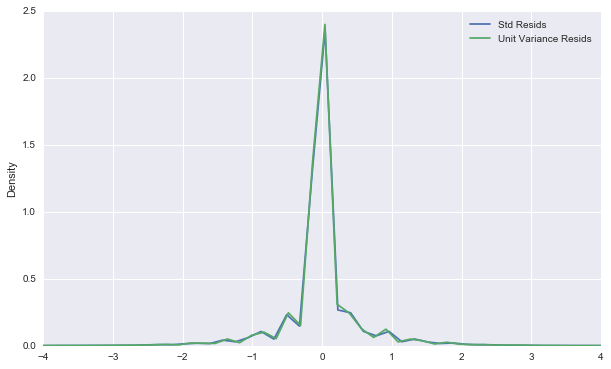

In [93]:
std_resid = res_normal.resid / res_normal.conditional_volatility
unit_var_resid = res_normal.resid / res_normal.resid.std()
df = pd.concat([std_resid, unit_var_resid],1)
df.columns = ['Std Resids', 'Unit Variance Resids']
df.plot(kind='kde', xlim=(-4,4))